Importing the libraries

In [6]:
import helpers as h
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sqlite3

Connecting to database

In [7]:
database = os.path.join("data","numbeo_db.sqlite")
conn = sqlite3.connect(database)

Checking the tables in database

In [8]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
tables

[('categories',),
 ('countries',),
 ('cities',),
 ('rents',),
 ('buy_apartments',),
 ('salaries',)]

Reading population dataset

In [9]:
selected_country_df = pd.read_csv(os.path.join('data','selected_countries.csv'))

Downloading the population numbers in Krakow. The data is necessary for further analysis.

In [10]:
cracow_population =selected_country_df['population'].loc[(selected_country_df['country']=='Poland')& (selected_country_df['city']=='Krakow')].values[0]
cracow_population

755050

The aim of the project is to compare the standard of living in European cities. Therefore, due to the fact that Russia's territory within Europe is small-Russian cities were excluded from further analysis.

In [11]:
selected_city = selected_country_df[(selected_country_df['population']>=cracow_population) & (selected_country_df['country']!='Russia')].sort_values(by='population')
selected_city.head(5)

,Unnamed: 0,city,population,country,lat,lng
173,51,Krakow,755050,Poland,50.0614,19.93660
172,50,Lodz,768755,Poland,51.7706,19.47390
43,49,Marseille,794811,France,43.2970,5.38107
288,48,Zaporizhia,796217,Ukraine,47.8229,35.19030
227,47,Valencia,814208,Spain,39.4697,-0.37739


According to the filtering conditions adopted, i.e., the size of the population in cities was checked, in which the number of cities in European countries that meet the said condition. 

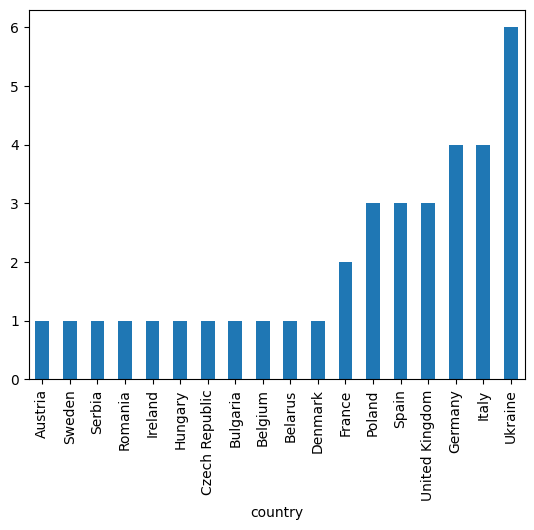

In [12]:
amount_cities_by_countries = selected_city.groupby(by='country')['city'].count().sort_values()
amount_cities_by_countries.plot.bar(x='country', y='city');

The plot above shows the number of cities in a country.
Based on the coordinates, a map of Europe was prepared with the location of selected cities.

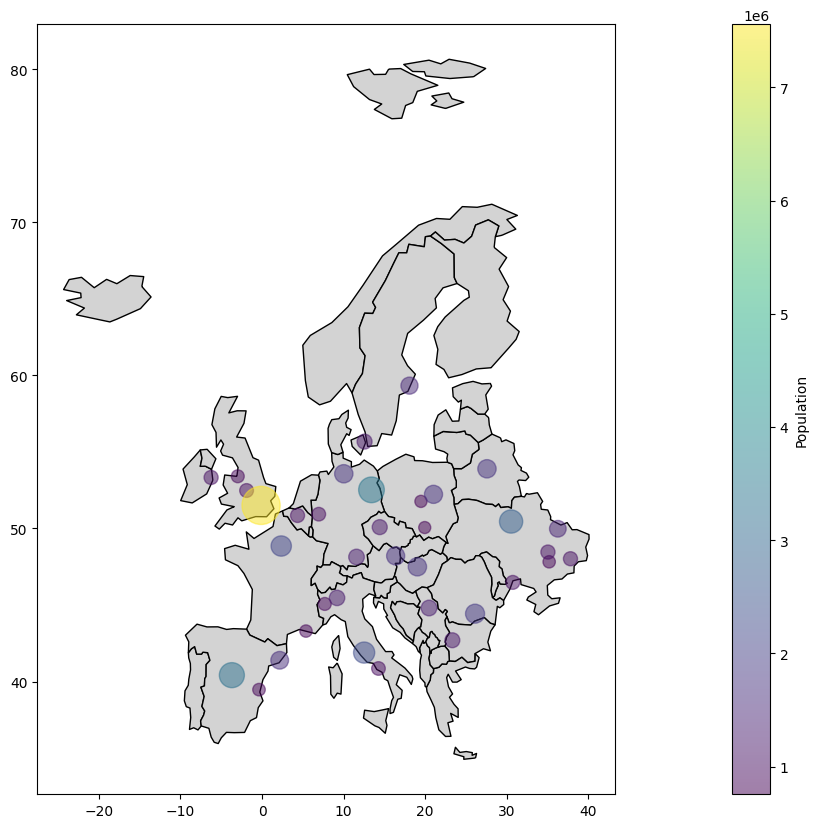

In [13]:
h.create_europe_map(df=selected_city, attributes=['population'], attribute_label='Population',cmap='viridis', size=10000, size_2=0)

Table `rents`

Based on a table of rents, I wanted to compare rental costs in selected cities depending on the number of bedrooms and the location of the apartment in the city: downtown/periphery of the city.

In [14]:
sql_query = pd.read_sql_query('''
select c.city, cc.country, apartment_1_bedroom_in_city_centre/100 as apartment_1_bedroom_in_city_centre ,
       apartment_1_bedroom_outside_of_centre/100 as apartment_1_bedroom_outside_of_centre,
       apartment_3bedrooms_in_city_centre/100 as apartment_3_bedrooms_in_city_centre,
       apartment_3bedrooms_outside_of_centre/100 as apartment_3_bedrooms_outside_of_centre
from rents r
join cities c on c.city_id = r.city_id
join countries cc on c.country_id = cc.country_id
''', conn)

The rental price is expressed in euros.

In [15]:
rent_population_df = pd.merge(selected_city[['city','country','lat', 'lng']],sql_query, right_on = ['city', 'country'], left_on =['city', 'country'])
rent_population_df.head(5)


,city,country,lat,lng,apartment_1_bedroom_in_city_centre,apartment_1_bedroom_outside_of_centre,apartment_3_bedrooms_in_city_centre,apartment_3_bedrooms_outside_of_centre
0,Krakow,Poland,50.0614,19.93660,816.0,604.0,1447.0,995.0
1,Lodz,Poland,51.7706,19.47390,597.0,447.0,1152.0,883.0
2,Marseille,France,43.2970,5.38107,811.0,592.0,1420.0,1296.0
3,Valencia,Spain,39.4697,-0.37739,959.0,719.0,1648.0,1055.0
4,Liverpool,United Kingdom,53.4106,-2.97794,979.0,684.0,1841.0,1008.0


Distribution of rental costs

In [16]:
columns = ['apartment_1_bedroom_in_city_centre',
       'apartment_1_bedroom_outside_of_centre',
       'apartment_3_bedrooms_in_city_centre',
       'apartment_3_bedrooms_outside_of_centre']
rent_population_df[columns].describe().round(2)

,apartment_1_bedroom_in_city_centre,apartment_1_bedroom_outside_of_centre,apartment_3_bedrooms_in_city_centre,apartment_3_bedrooms_outside_of_centre
count,32.00,32.00,32.00,32.00
mean,1004.12,734.12,1838.47,1284.47
std,499.11,396.26,925.67,671.80
min,225.00,153.00,570.00,338.00
25%,668.25,456.75,1173.00,853.25
50%,978.00,703.50,1825.00,1255.00
75%,1256.50,947.50,2162.25,1547.00
max,2585.00,1897.00,4906.00,3194.00


In the chart below, you can see that housing prices vary widely, outliers are visible, which, with a closer look at the data, should be removed. However, due to the purpose of the project, this is not important for further analysis.

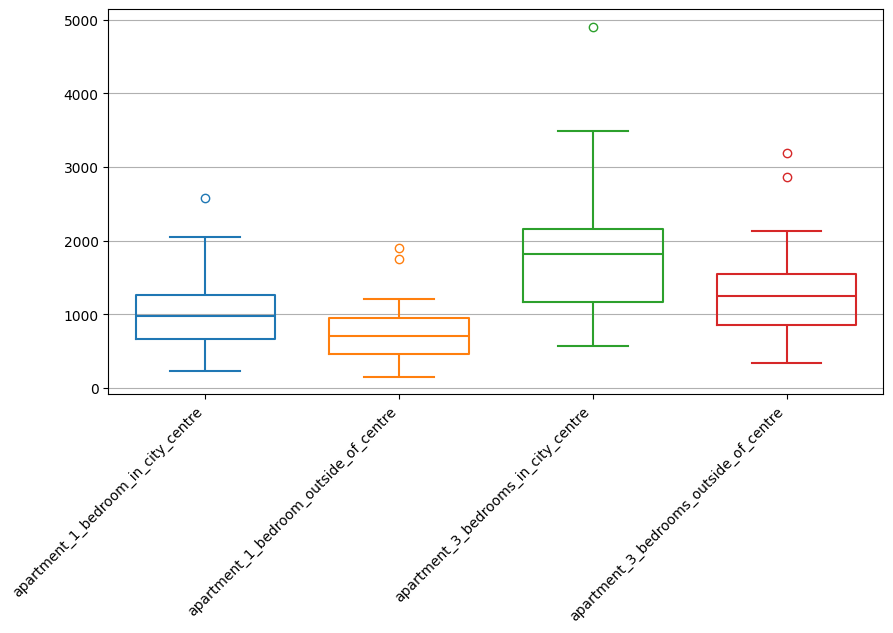

In [17]:
plt.figure(figsize=(10,5))
sns.set_style({'axes.grid' : True})
sns.boxplot(rent_population_df[columns], fill=False, gap=.1)
plt.xticks(rotation=45, ha='right')
plt.show();


Maps comparing rental costs center vs edges of cities

On the map for a given city, 2 dots are marked:the larger one indicates the price on the outskirts of the city, and the smaller one in the center. The greater the difference in color, the greater the disparity in prices.

* Apartment with 1 bedroom

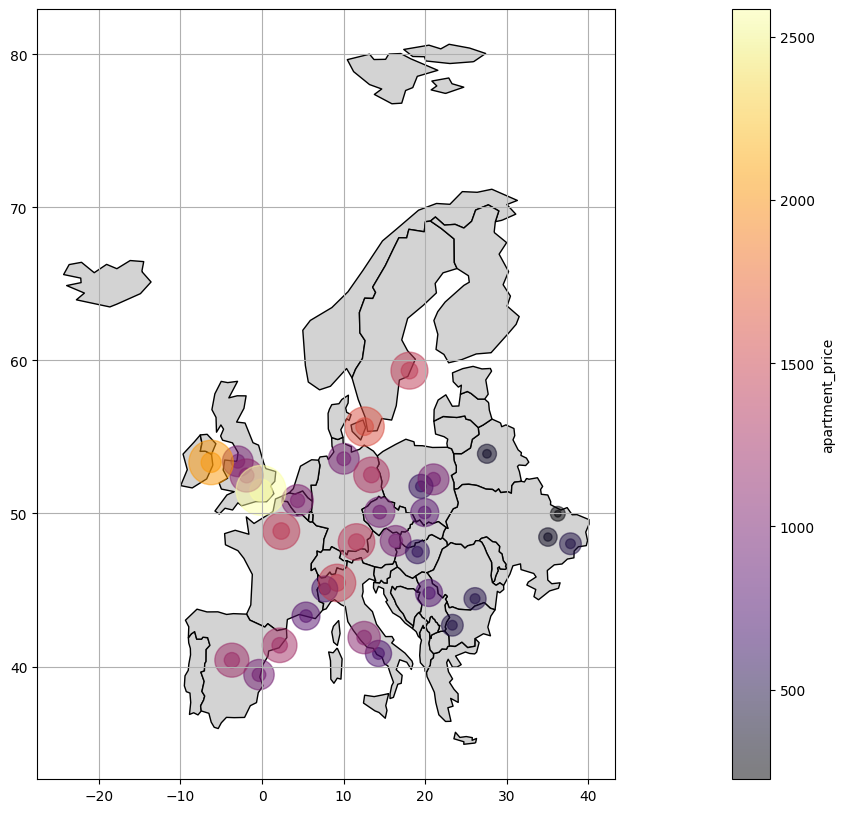

In [18]:
h.create_europe_map(df=rent_population_df, attributes= ['apartment_1_bedroom_in_city_centre','apartment_1_bedroom_outside_of_centre'], 
attribute_label='apartment_price', cmap='inferno', size = 10, size_2=2)


* Apartment with 3 bedrooms

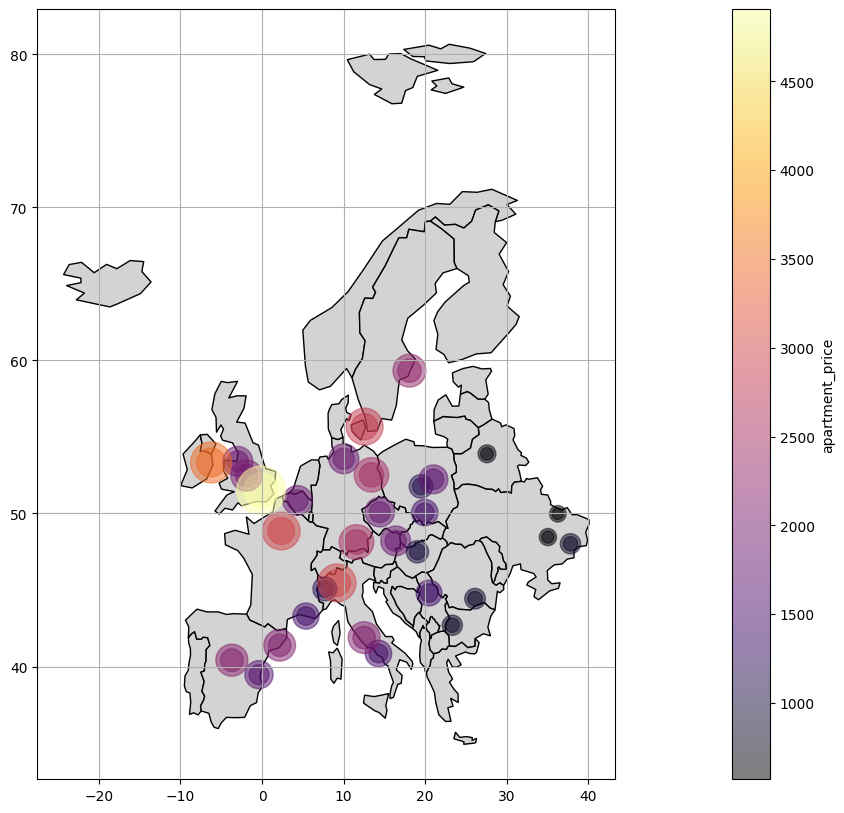

In [19]:
h.create_europe_map(df=rent_population_df, attributes= ['apartment_3_bedrooms_in_city_centre','apartment_3_bedrooms_outside_of_centre'], 
attribute_label='apartment_price', cmap='inferno', size=8, size_2=4)

As you can see, there are definitely more expensive apartments in Western Europe than in Eastern Europe. In Poland, prices are close to the average prices in Central Europe. The most expensive apartments were recorded in the UK. In addition, in the UK, no major differences were observed between the cost of rent depending on the location of the apartment (downtown/neighborhood) .

Purchase of an apartment - 50 m<sup>2</sup>

In [20]:
sql_query= pd.read_sql_query('''
  select c.city, cc.country,
  50 * price_per_square_meter_outside_of_centre/100 as avg_price_apartment_outside_city,
  50* price_per_square_meter_in_city_centre/100 as avg_price_apartment_centre_city
  from buy_apartments r 
  join cities c on r.city_id = c.city_id
  join countries cc on c.country_id = cc.country_id
  where price_per_square_meter_outside_of_centre>0
  ''', conn)


In [21]:
buy_apartment_df = pd.merge(selected_city[['city','country']],sql_query, right_on = ['city', 'country'], left_on =['city', 'country']).set_index('city').sort_values(by='avg_price_apartment_centre_city')
buy_apartment_df.head(5)

,country,avg_price_apartment_outside_city,avg_price_apartment_centre_city
city,,,
Dnipro,Ukraine,39649,51444.0
Kharkiv,Ukraine,35170,62593.0
Minsk,Belarus,53068,84435.0
Valencia,Spain,67626,110870.0
Lodz,Poland,91022,119826.0


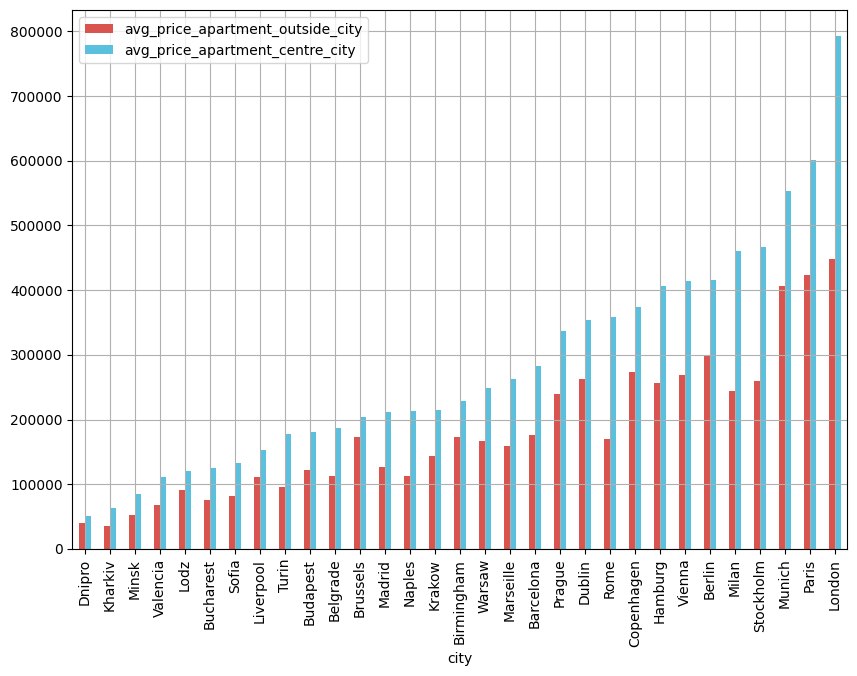

In [22]:
buy_apartment_df.plot(kind="bar",figsize=(10, 7),color=['#d9534f','#5bc0de']);

The chart above shows a comparison of average prices of apartments (50 m<sup>2</sup>) depending on the location of the apartment (downtown/neighborhood)

Salary

In [23]:
sql_query= pd.read_sql_query('''
  select c.city,cc.country, r.average_monthly_net_salary/100 as avg_salary
   from salaries r
   join cities c on r.city_id = c.city_id 
   join countries cc on c.country_id = cc.country_id
  ''', conn)


In [24]:
salary_df = pd.merge(selected_city[['city','country','lat', 'lng']],sql_query, right_on = ['city', 'country'], left_on =['city', 'country']).set_index('city').sort_values(by='avg_salary')
salary_df.head(5)

,country,lat,lng,avg_salary
city,,,,
Donetsk,Ukraine,48.0230,37.8022,126.0
Kharkiv,Ukraine,49.9808,36.2527,357.0
Dnipro,Ukraine,48.4593,35.0387,381.0
Minsk,Belarus,53.9000,27.5667,544.0
Belgrade,Serbia,44.8040,20.4651,765.0


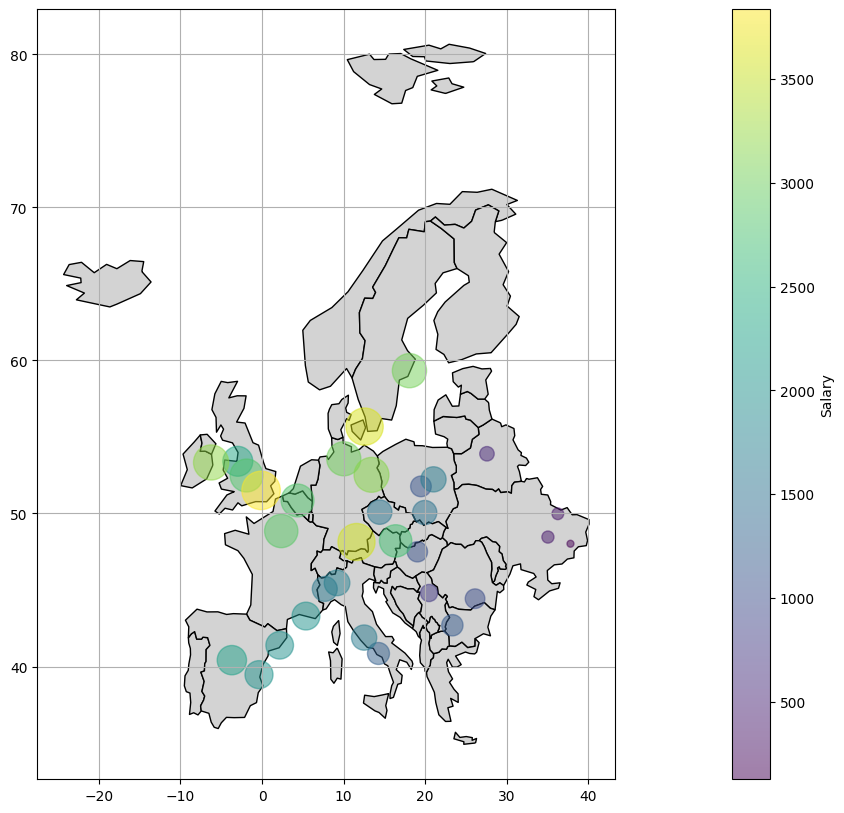

In [25]:
h.create_europe_map(df=salary_df, attributes=['avg_salary'], attribute_label='Salary', cmap='viridis', size=5);

The map shows average earnings in the cities in question. As you can see, the lowest wages are in the former Soviet Union countries. In the case of Poland, earnings approximate those achievable in Mediterranean countries. 

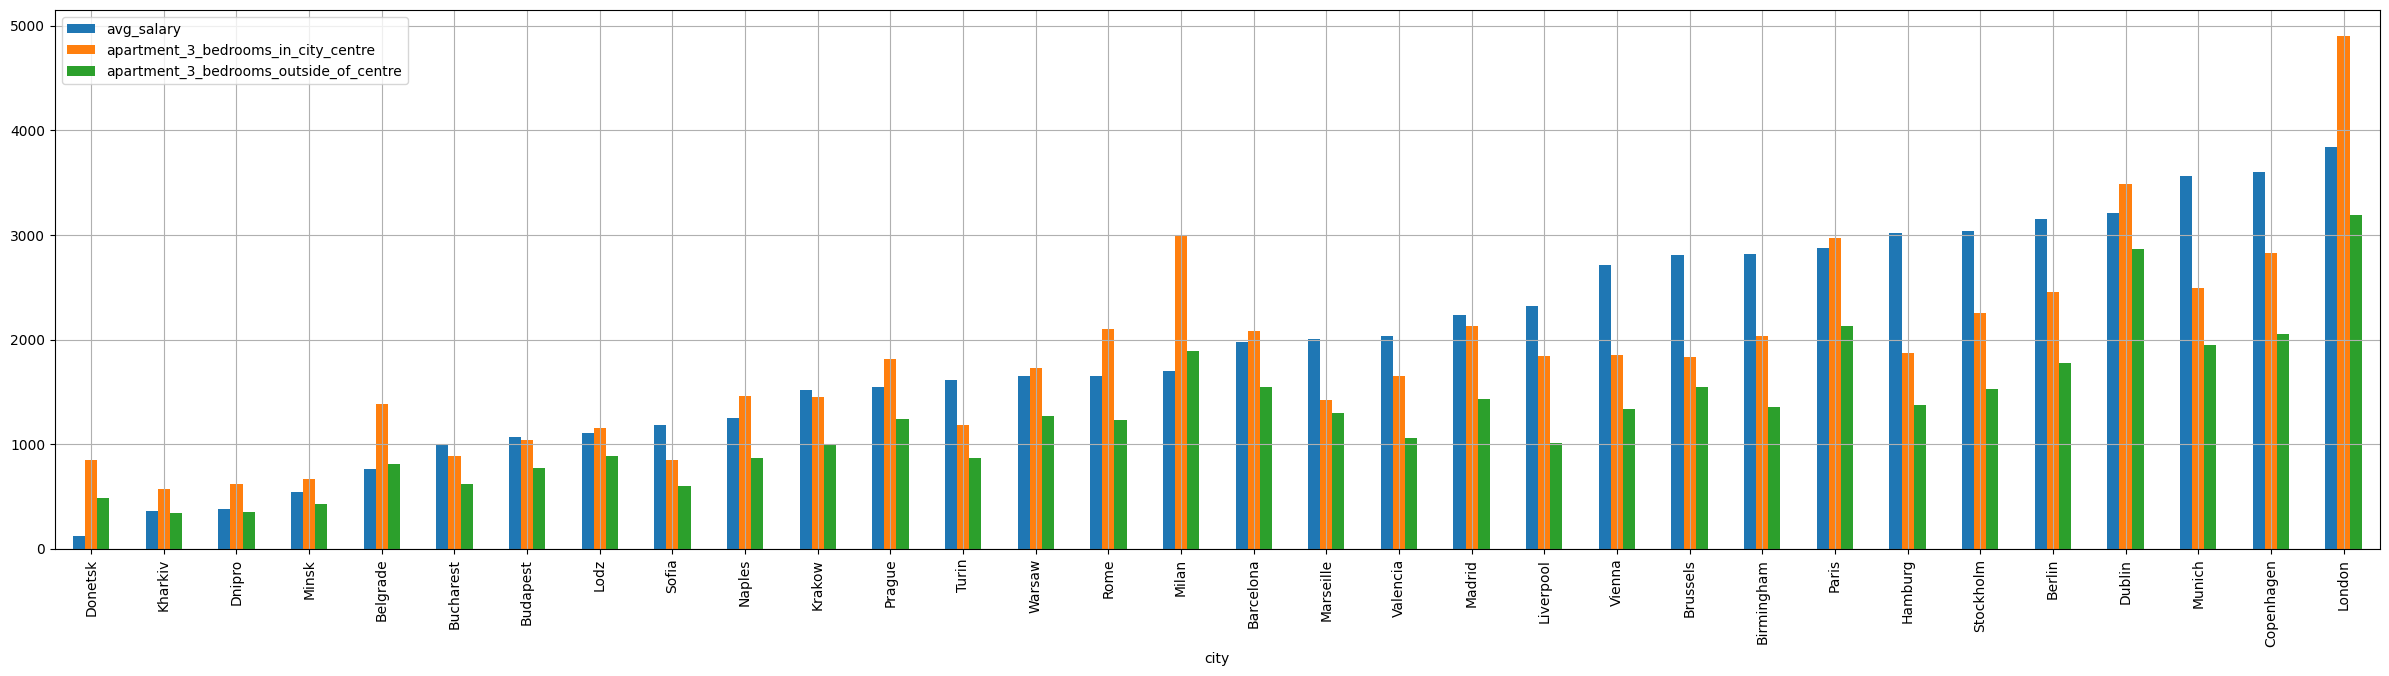

In [26]:
salary_df.reset_index()
salary_rent=pd.merge(left=salary_df, right=rent_population_df, on='city')
df = salary_rent[['city','avg_salary', 'apartment_3_bedrooms_in_city_centre','apartment_3_bedrooms_outside_of_centre']].set_index('city')
df.plot(kind="bar",figsize=(30, 7));


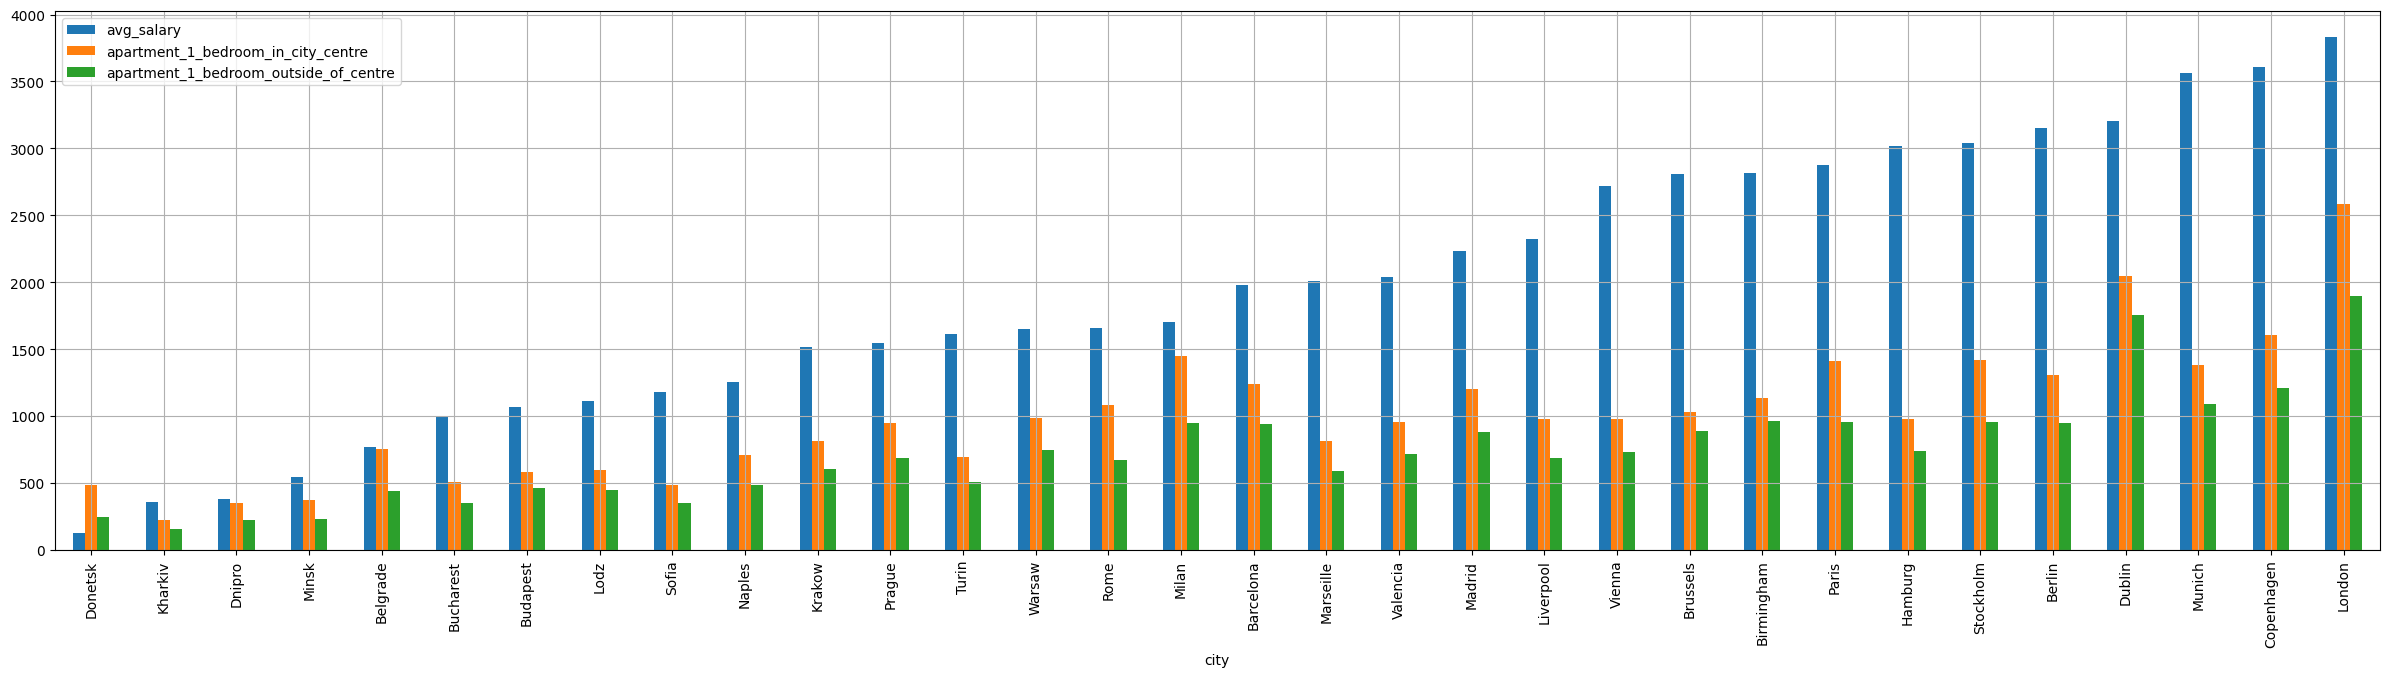

In [27]:

df = salary_rent[['city','avg_salary', 'apartment_1_bedroom_in_city_centre','apartment_1_bedroom_outside_of_centre']].set_index('city')
df.plot(kind="bar",figsize=(30, 7));


Looking at charts comparing the cost of renting an apartment versus earnings, one can see that across Europe, a single with average earnings in a country can afford to rent a 1-bedroom apartment on their own. The situation is much worse for 3-bedroom apartments, here the differences between the cost of rent and earnings are very large.

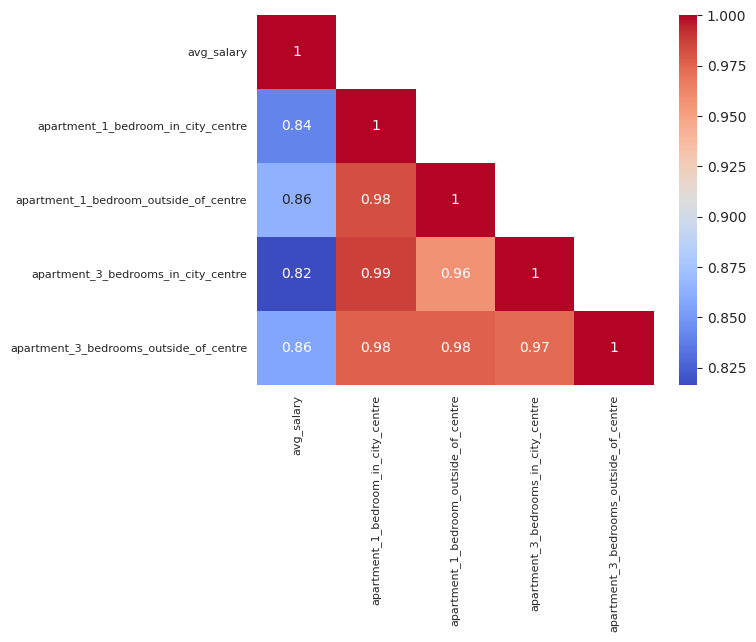

In [28]:
df = salary_rent[['city','avg_salary', 'apartment_1_bedroom_in_city_centre','apartment_1_bedroom_outside_of_centre', 'apartment_3_bedrooms_in_city_centre','apartment_3_bedrooms_outside_of_centre']]
corr_df = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))
np.fill_diagonal(mask, False)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.heatmap(corr_df, cmap="coolwarm", annot=True, mask=mask)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

Based on the heatmap, we can deduce that the amount of rent depends not only on the location of the apartment, but also on average earnings.